## <center>Word2Vec</center>

#### Neural Language Model

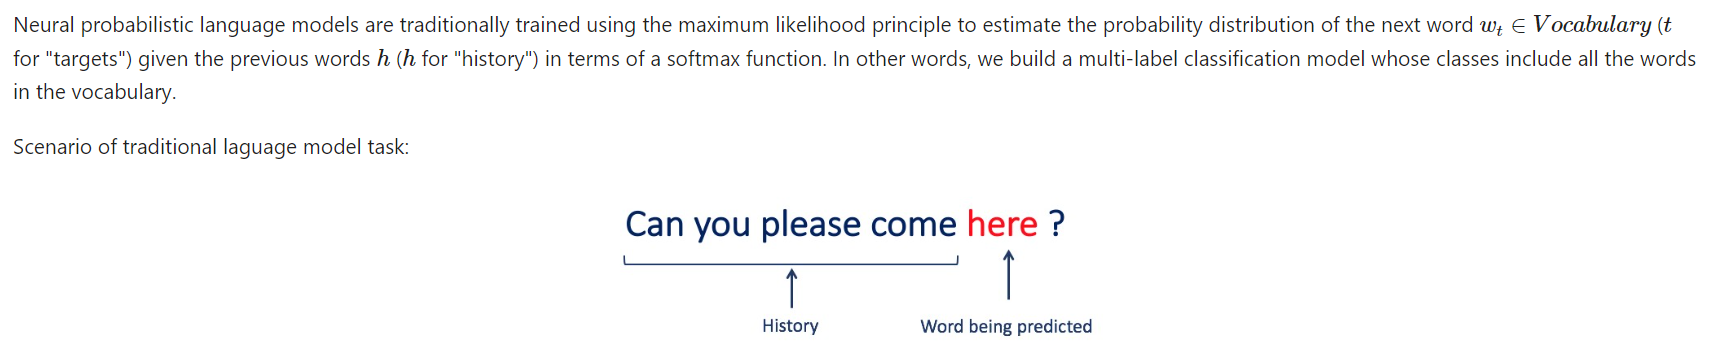

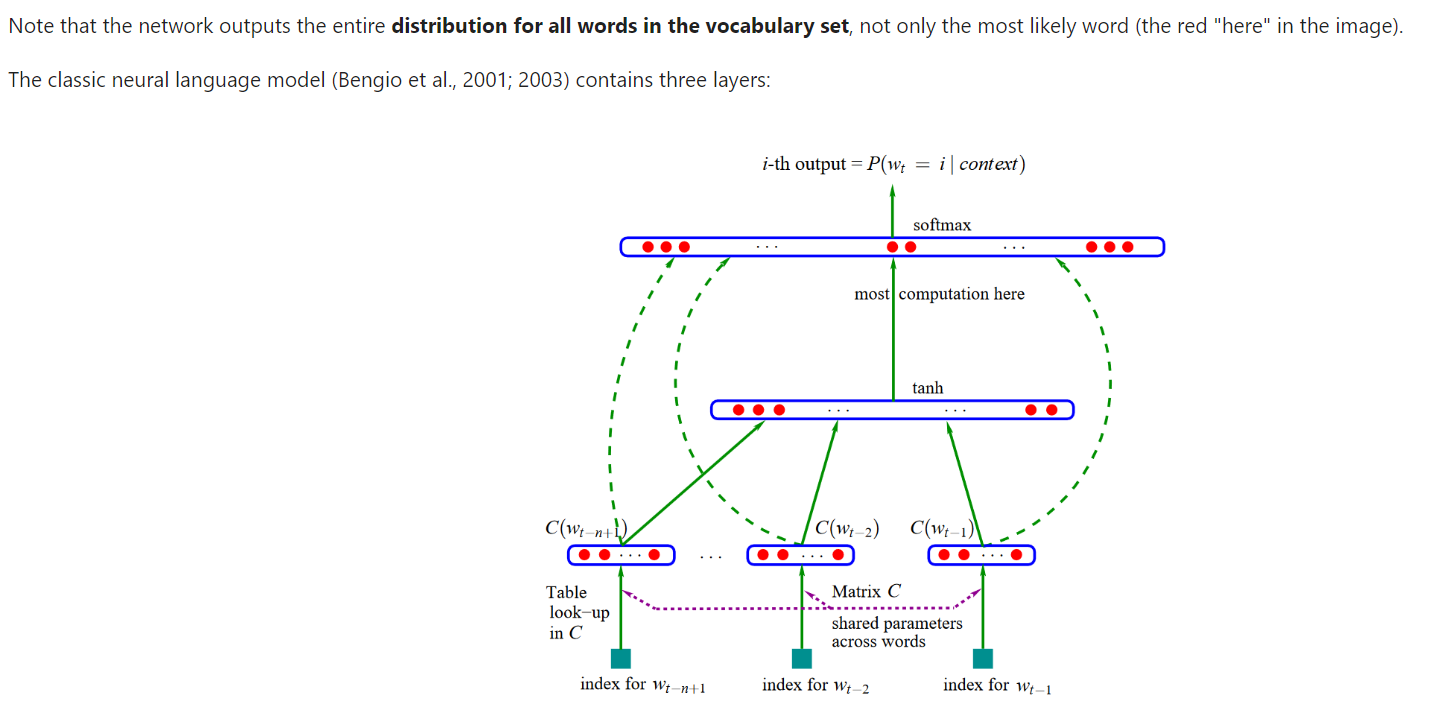

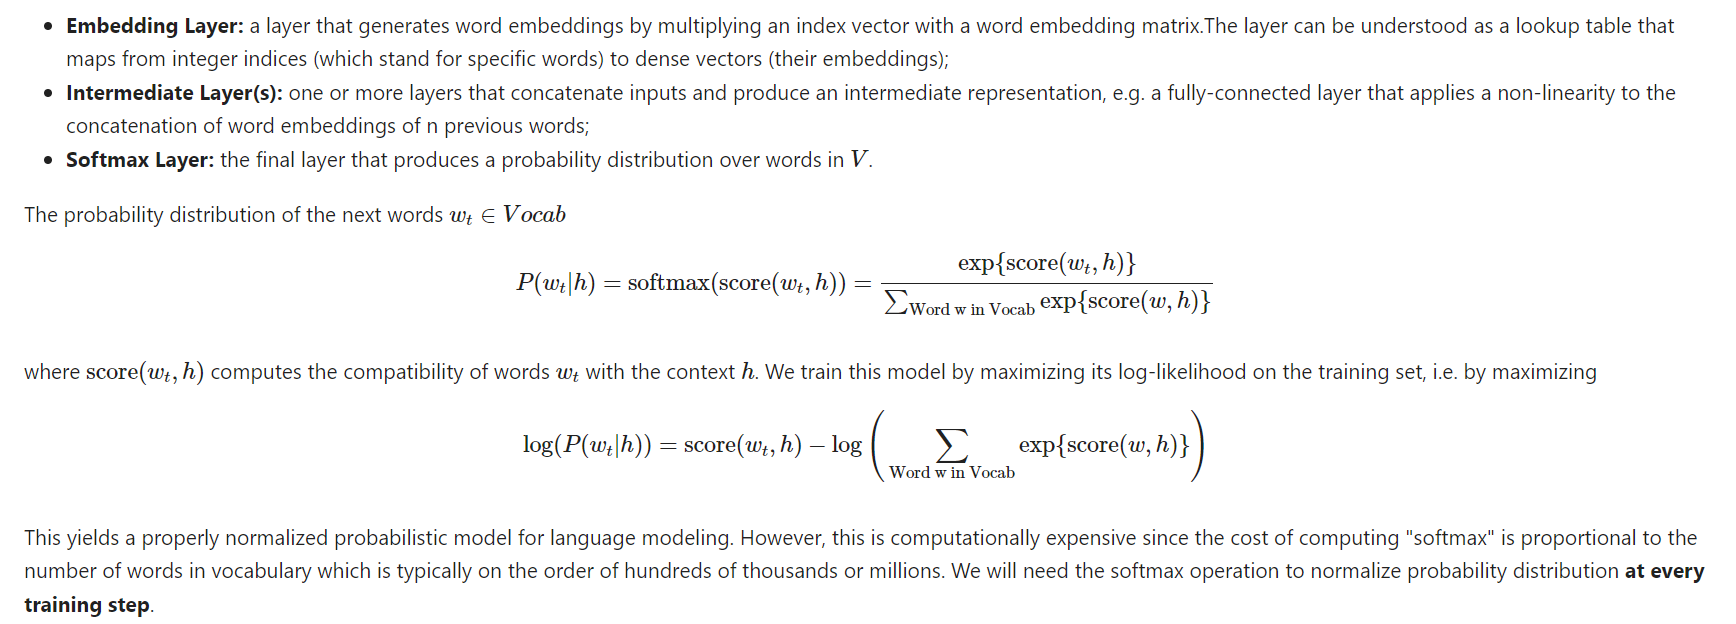

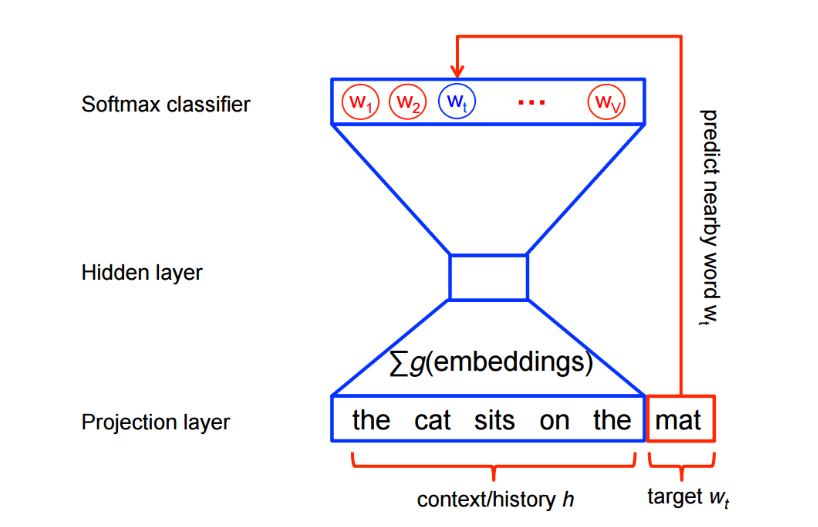

### Skip-gram with NCE Loss in TensorFlow
#### The Dataset
The dataset we use is **text8**, which is the first 100 MB of cleaned text of the English Wikipedia dump on Mar. 3, 2006. While 100MB is not enough to train really good embeddings, we can still see some interesting relations. Splitting the text by blank space, we can find that there are 17,005,207 tokens in total.

#### Preparing training data
To generate batches for training, several functions defined below are used. First, we read the data into the memory and build the vocabulary using a number of most commonly seen words. Meanwhile, we build two dictionaries, a dictionary that translates words to indices and another which does the reverse. Then, for every word in the text selected as the center word, pair them with one of the context words. Finally, a python generator which generates a batch of pairs of center-target pairs.

這段文字描述了使用TensorFlow實現Skip-gram模型與NCE（Noise Contrastive Estimation）損失函數的過程，以及準備訓練資料的步驟。 以下是這些步驟的中文解釋： 資料集：使用的資料集是text8，它是英文維基百科在2006年3月3日的倒排索引中清理後的前100MB文字資料。 雖然100MB的資料不足以訓練出非常好的詞嵌入模型，但我們仍然可以觀察到一些有趣的詞彙關係。 資料集被拆分成單詞，並總共包含17,005,207個單字標記。 準備訓練數據：為了產生用於訓練的批次數據，下面定義了一些函數。 首先，將資料讀入內存，並建立一個包含最常見單字的詞彙表。 同時，建立兩個字典，一個將單字轉換為索引，另一個將索引轉換回單字。 然後，對於文本中的每個單詞，將其選為中心詞，並將其與上下文詞之一配對。 最後，建立一個Python生成器，用於產生一批中心-目標詞對。 

Skip-gram模型是用於學習單字嵌入（word embeddings）的深度學習模型，它可以用於捕捉單字之間的語義關係。 

NCE損失函數則用於訓練這個模型，它透過將正例（中心詞-目標詞對）與負例（中心詞-噪音詞對）進行比較來進行訓練。 這個過程有助於提高模型的效率和性能。

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning and info message
import tensorflow as tf
import numpy as np
import random

2023-11-01 15:34:36.698029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 15:34:36.698052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 15:34:36.698070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 用於獲取系統上可用的物理 GPU 裝置清單，並將其存儲在 gpus 變數中
gpus = tf.config.experimental.list_physical_devices('GPU')
# 確保至少有一個 GPU 裝置可用
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


1. `file_name, _ = urllib.request.urlretrieve(os.path.join(DOWNLOAD_URL, file_name), local_file_path)`：這行程式碼使用Python 的`urllib.request` 模組中的`urlretrieve` 函數從指定的URL 位址（`os.path.join(DOWNLOAD_URL, file_name)`）下載文件，並將下載後的文件儲存到本機檔案路徑`local_file_path`。 函數的傳回值是一個包含下載後的檔案名稱和 HTTP 頭資訊的元組，但在這裡只提取了檔案名稱並賦值給 `file_name`。 HTTP 頭資訊會被忽略，因此以 `_` 表示。

2. `file_stat = os.stat(local_file_path)`：這行程式碼使用 Python 的 `os` 模組中的 `stat` 函數來取得下載後檔案的狀態信息，包括檔案大小、建立時間等。 `local_file_path` 是檔案的本機路徑，函數傳回的結果儲存在 `file_stat` 變數中，以便後續檢查檔案大小是否符合預期。

總而言之，這兩行程式碼的目的是下載檔案並獲取下載檔案的狀態信息，以便後續驗證檔案是否下載成功且檔案大小正確。

In [3]:
import os
import urllib

# Download the data.
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
DATA_FOLDER = "data"
FILE_NAME = "text8.zip"
EXPECTED_BYTES = 31344016

def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
    
def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    local_file_path = os.path.join(DATA_FOLDER, file_name)
    if os.path.exists(local_file_path):
        print("Dataset ready")
        return local_file_path
    file_name, _ = urllib.request.urlretrieve(os.path.join(DOWNLOAD_URL, file_name), local_file_path)
    file_stat = os.stat(local_file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception(
              'File ' + file_name +
              ' might be corrupted. You should try downloading it with a browser.')
    return local_file_path    
    
make_dir(DATA_FOLDER)
file_path = download(FILE_NAME, EXPECTED_BYTES)

Dataset ready


In [4]:
import zipfile

# Read the data into a list of strings.
def read_data(file_path):
    """ Read data into a list of tokens """
    with zipfile.ZipFile(file_path) as f:
        # tf.compat.as_str() converts the input into string
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(file_path)
print('Data size', len(vocabulary))

Data size 17005207


In [5]:
vocabulary[:5]

['anarchism', 'originated', 'as', 'a', 'term']

### Build the dictionary

In CBOW and skip-gram, negative reinforcement can be approximated with non-context word pairs.

In [6]:
import collections
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """ Create two dictionaries and count of occuring words
        - word_to_id: map of words to their codes
        - id_to_word: maps codes to words (inverse word_to_id)
        - count: map of words to count of occurrences
    """
    # (建立一個清單 `count`，初始包含一個元素 ['UNK', -1]，表示未知單字的計數為 -1)
    count = [['UNK', -1]]
    # 使用 `collections.Counter(words)` 統計文字資料集中每個單字的出現次數，並按出現次數從高到低排序。
    # 將出現次數最高的 `n_words - 1` 個字加入 `count` 清單中。 這些單字的出現次數和排名資訊被記錄在 `count` 清單中。
    count.extend(collections.Counter(words).most_common(n_words - 1)) 
    # 建立一個空字典 `word_to_id` 用於將單字對應到它們的編碼（ID）
    word_to_id = dict() # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys())) # (id, word)
    return word_to_id, id_to_word, count

def convert_words_to_id(words, dictionary, count):
    """ Replace each word in the dataset with its index in the dictionary """
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        # 函數遍歷文字資料集中的每個單字，如果單字存在於字典中，則將其編碼新增至 `data_w2id` 清單中。 如果單字未在字典中找到，則將其編碼為 0，表示未知單詞，並將未知單字的計數 `unk_count` 增加 1。
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count

In [7]:
"""Filling 4 global variables:
# data_w2id - list of codes (integers from 0 to vocabulary_size-1).
              This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# word_to_id - map of words(strings) to their codes(integers)
# id_to_word - maps codes(integers) to words(strings)
"""

vocabulary_size = 50000
word_to_id, id_to_word, count = build_dataset(vocabulary, vocabulary_size)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)
del vocabulary  # reduce memory.

In [8]:
print('Most common words (+UNK)', count[:5])
print('Sample data: {}'.format(data_w2id[:10]))
print([id_to_word[i] for i in data_w2id[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [9]:
# utility function
def generate_sample(center_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for idx, center in enumerate(center_words):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in center_words[max(0, idx - context) : idx]:
            yield center, target
        # get a random target after the center word
        for target in center_words[idx + 1 : idx + context + 1]:
            yield center, target

def batch_generator(data, skip_window, batch_size):
    """ Group a numeric stream into batches and yield them as Numpy arrays. """
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch

Skip-gram word2vec model
Reference:

- [Writing custom layers and models with Keras](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing)

In [10]:
## some training settings
training_steps = 80000
skip_step = 2000

## some hyperparameters
batch_size = 512
embed_size = 512
num_sampled = 256
learning_rate = 1.0

- Layer Subclassing

當使用 TensorFlow 建立 Skip-gram 模型時，通常需要兩個關鍵元件：嵌入層和 NCE（Noise-Contrastive Estimation）損失層。 這兩個組件在 Skip-gram 模型中的作用如下：

嵌入層 (embedding_lookup 自訂層):

嵌入層用於將輸入的單字編碼（通常是中心詞的編碼）轉換為對應的嵌入向量。
在初始化時，嵌入層會建立一個嵌入矩陣，其形狀為 [vocabulary_size, embed_size]，其中 vocabulary_size 表示詞彙表的大小，embed_size 表示嵌入向量的維度。 這個矩陣將用於將單字編碼映射到嵌入向量。
call 方法接受輸入，通常是中心詞的編碼。 它使用 tf.nn.embedding_lookup 函數，將輸入編碼尋找在嵌入矩陣中對應的行，以獲得對應的嵌入向量。
嵌入向量表示了單字在嵌入空間中的位置，這些向量將用於模型的訓練和學習，以便更好地捕捉單字之間的語義關係。
NCE 損失層 (nce_loss 自訂圖層):

NCE 損失層用於計算損失，以評估模型的性能。 NCE 是一種用於估計模型的分類性能的損失函數。
初始化時，NCE 損失層會建立兩個參數：權重（nce_weight）和偏壓（nce_bias）。 這些參數將在訓練中學習，以便模型可以進行單字預測。
call 方法接受輸入，包括嵌入向量和目標字的編碼。 它使用 tf.nn.nce_loss 函數，計算模型的 NCE 損失。 NCE 損失用於測量模型的預測與真實目標之間的偏差。
NCE 損失通常用於 Skip-gram 模型中，其中模型的任務是根據中心詞預測周圍的上下文詞。 這個損失函數可以幫助模型學習單字之間的關係，以便更好地進行單字嵌入學習。
這兩個自訂層協同工作，建構了 Skip-gram 模型的關鍵部分。 嵌入層將輸入的單字編碼映射到嵌入向量，而 NCE 損失層用於評估模型的性能，並驅動模型學習有關單字的語義資訊。 這是一個典型的詞嵌入模型，用於將單字表示為連續向量以進行自然語言處理任務。

In [11]:
# from tensorflow.keras.layers import Layer
from tensorflow.python.keras.layers import Layer

# embedding matrix - hidden layer
class embedding_lookup(Layer):
    def __init__(self):
        super(embedding_lookup, self).__init__()
        # 用于初始化神经网络中的权重参数
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                                trainable=True,
                                                shape=[vocabulary_size, embed_size],
                                                initializer=embedding_init)

    def call(self, inputs):
        center_words = inputs
        embedding = tf.nn.embedding_lookup(self.embedding_matrix,
                                           center_words, 
                                           name='embedding')
        return embedding

# context matrix - prediction layer
class nce_loss(Layer):
    def __init__(self):
        super(nce_loss, self).__init__()
        nce_w_init = tf.keras.initializers.TruncatedNormal(stddev=1.0/(embed_size ** 0.5))
        self.nce_weight = self.add_weight(name='nce_weight',
                                          trainable=True,
                                          shape=[vocabulary_size, embed_size],
                                          initializer=nce_w_init)
        self.nce_bias = self.add_weight(name='nce_bias',
                                        trainable=True,
                                        shape=[vocabulary_size],
                                        initializer=tf.keras.initializers.Zeros)

    def call(self, inputs):
        embedding, target_words = inputs[0], inputs[1]
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                             biases=self.nce_bias, 
                                             labels=target_words, 
                                             inputs=embedding, 
                                             num_sampled=num_sampled, 
                                             num_classes=vocabulary_size),
                                             name='loss')
        return loss

- Functional API

這部分程式碼用於建立 Word2Vec 模型，包括輸入層、嵌入層和 NCE 損失層，最後將它們組合成一個 Word2Vec 模型。 首先，導入了需要的函式庫，包括 Model 和 Input。 這些庫用於建立和定義 Keras 模型。 center_words 和 target_words 分別是輸入的中心詞和目標詞。 它們被定義為 Keras 的輸入層（Input），並指定了它們的資料類型為整數（'int32'）。 接下來，透過呼叫先前定義的嵌入層 embedding_lookup() 來獲得中心詞的嵌入向量。 這個操作將中心詞的編碼（整數）映射為對應的嵌入向量，這些嵌入向量將在 Word2Vec 模型中被訓練。 然後，定義了 NCE 損失層 nce_loss() 的輸入，包括嵌入向量和目標字的編碼。 NCE 損失層將使用這些輸入來計算損失，該損失用於衡量模型的性能。 最後，使用 Model 類別建立了一個名為 "word2vec" 的 Keras 模型。 這個模型有兩個輸入：center_words 和 target_words，以及一個輸出：loss，即 NCE 損失。 這將構成 Word2Vec 模型的整體架構。 透過將這些元件組合成一個 Keras 模型，您可以輕鬆地進行訓練和評估 Word2Vec 模型，以學習單字的嵌入表示並執行單字向量空間中的各種自然語言處理任務。

在 Keras 的 Input 層中，shape=() 表示空的形狀。 這意味著輸入資料的形狀是可變的，不需要明確指定形狀。 通常，shape 參數用於定義輸入資料的維度，例如 (batch_size, input_dim)，其中 batch_size 是批次大小，而 input_dim 是輸入資料的維度。 但在某些情況下，您可能想要定義一個維度可變的輸入，以適應不同大小的輸入資料。 這時，您可以使用 shape=() 來表示輸入資料的形狀是可變的，也就是不需要預先指定。 這對於某些類型的模型或任務可能是有用的，因為它允許您接受不同大小的輸入資料而無需明確指定其形狀。 在上述程式碼中，center_words 的形狀被設定為 shape=()，這表示它是一個可變形狀的輸入，可以接受不同大小的中心詞編碼。 這通常在 NLP（自然語言處理）任務中很有用，因為輸入句子的長度可能會不同。

In [12]:
# from tensorflow.keras import Model, Input
from tensorflow.python.keras import Model, Input

center_words = Input(shape=(), name='center_words', dtype='int32')
target_words = Input(shape=(1), name='target_words', dtype='int32')

embedding = embedding_lookup()(center_words)
loss = nce_loss()((embedding, target_words))

word2vec = Model(name='word2vec',
                 inputs=[center_words, target_words],
                 outputs=[loss])

In [13]:
word2vec.summary()

Model: "word2vec"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
center_words (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_lookup (embedding_loo (None, 512)          25600000    center_words[0][0]               
__________________________________________________________________________________________________
target_words (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nce_loss (nce_loss)             ()                   25650000    embedding_lookup[0][0]           
                                                                 target_words[0][0]        

In [14]:
## geneartor for `tf.data.Dataset`
def gen():
    """ Return a python generator that generates batches. """
    yield from batch_generator(data_w2id, 2, batch_size)

    

dataset = tf.data.Dataset.from_generator(gen, 
                                         (tf.int32, tf.int32),
                                         (tf.TensorShape([batch_size]), tf.TensorShape([batch_size, 1])))\
                         .repeat()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1,nesterov=True)

In [16]:
@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = word2vec([center_words, target_words])
    gradients = tape.gradient(loss, word2vec.trainable_variables)
    optimizer.apply_gradients(zip(gradients, word2vec.trainable_variables))

    train_loss(loss)

In [17]:
x = []
y = []
for step, (center_words, target_words) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(center_words, target_words)

    if ((step+1) % skip_step) == 0:
        template = 'Step {:0}, Loss: {:.2f}'
        x.append(step+1)
        y.append(train_loss.result())
        print(template.format(step+1, train_loss.result()))
        train_loss.reset_states()

Step 2000, Loss: 174.29
Step 4000, Loss: 31.96
Step 6000, Loss: 15.44
Step 8000, Loss: 10.77
Step 10000, Loss: 9.59
Step 12000, Loss: 8.75
Step 14000, Loss: 8.13
Step 16000, Loss: 7.45
Step 18000, Loss: 7.15
Step 20000, Loss: 6.98
Step 22000, Loss: 6.90
Step 24000, Loss: 6.72
Step 26000, Loss: 6.59
Step 28000, Loss: 6.41
Step 30000, Loss: 6.44
Step 32000, Loss: 6.36
Step 34000, Loss: 6.25
Step 36000, Loss: 6.28
Step 38000, Loss: 6.14
Step 40000, Loss: 6.16
Step 42000, Loss: 6.12
Step 44000, Loss: 5.95
Step 46000, Loss: 5.94
Step 48000, Loss: 5.97
Step 50000, Loss: 5.90
Step 52000, Loss: 5.89
Step 54000, Loss: 5.95
Step 56000, Loss: 5.89
Step 58000, Loss: 5.84
Step 60000, Loss: 5.91
Step 62000, Loss: 5.83
Step 64000, Loss: 5.80
Step 66000, Loss: 5.87
Step 68000, Loss: 5.81
Step 70000, Loss: 5.73
Step 72000, Loss: 5.81
Step 74000, Loss: 5.77
Step 76000, Loss: 5.45
Step 78000, Loss: 5.60
Step 80000, Loss: 5.70


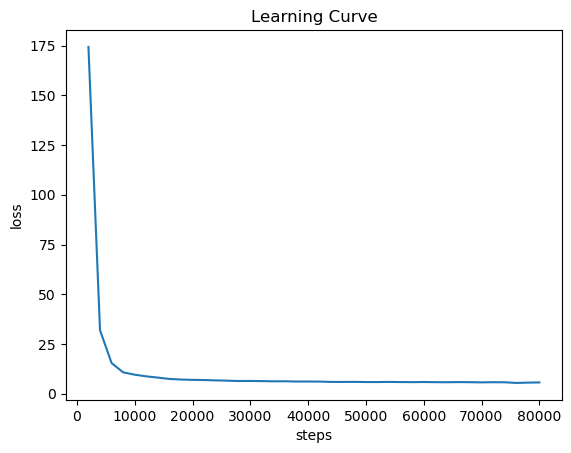

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()

### Visualizing the learned embeddings

After training we can visualize the learned embeddings using t-SNE.
We can see that similar words are near to each other.

In [22]:
# get embedding matrix from model weights. > word2vec.weights[0]
embedding_matrix = word2vec.weights[0]

In [23]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18), dpi=150)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

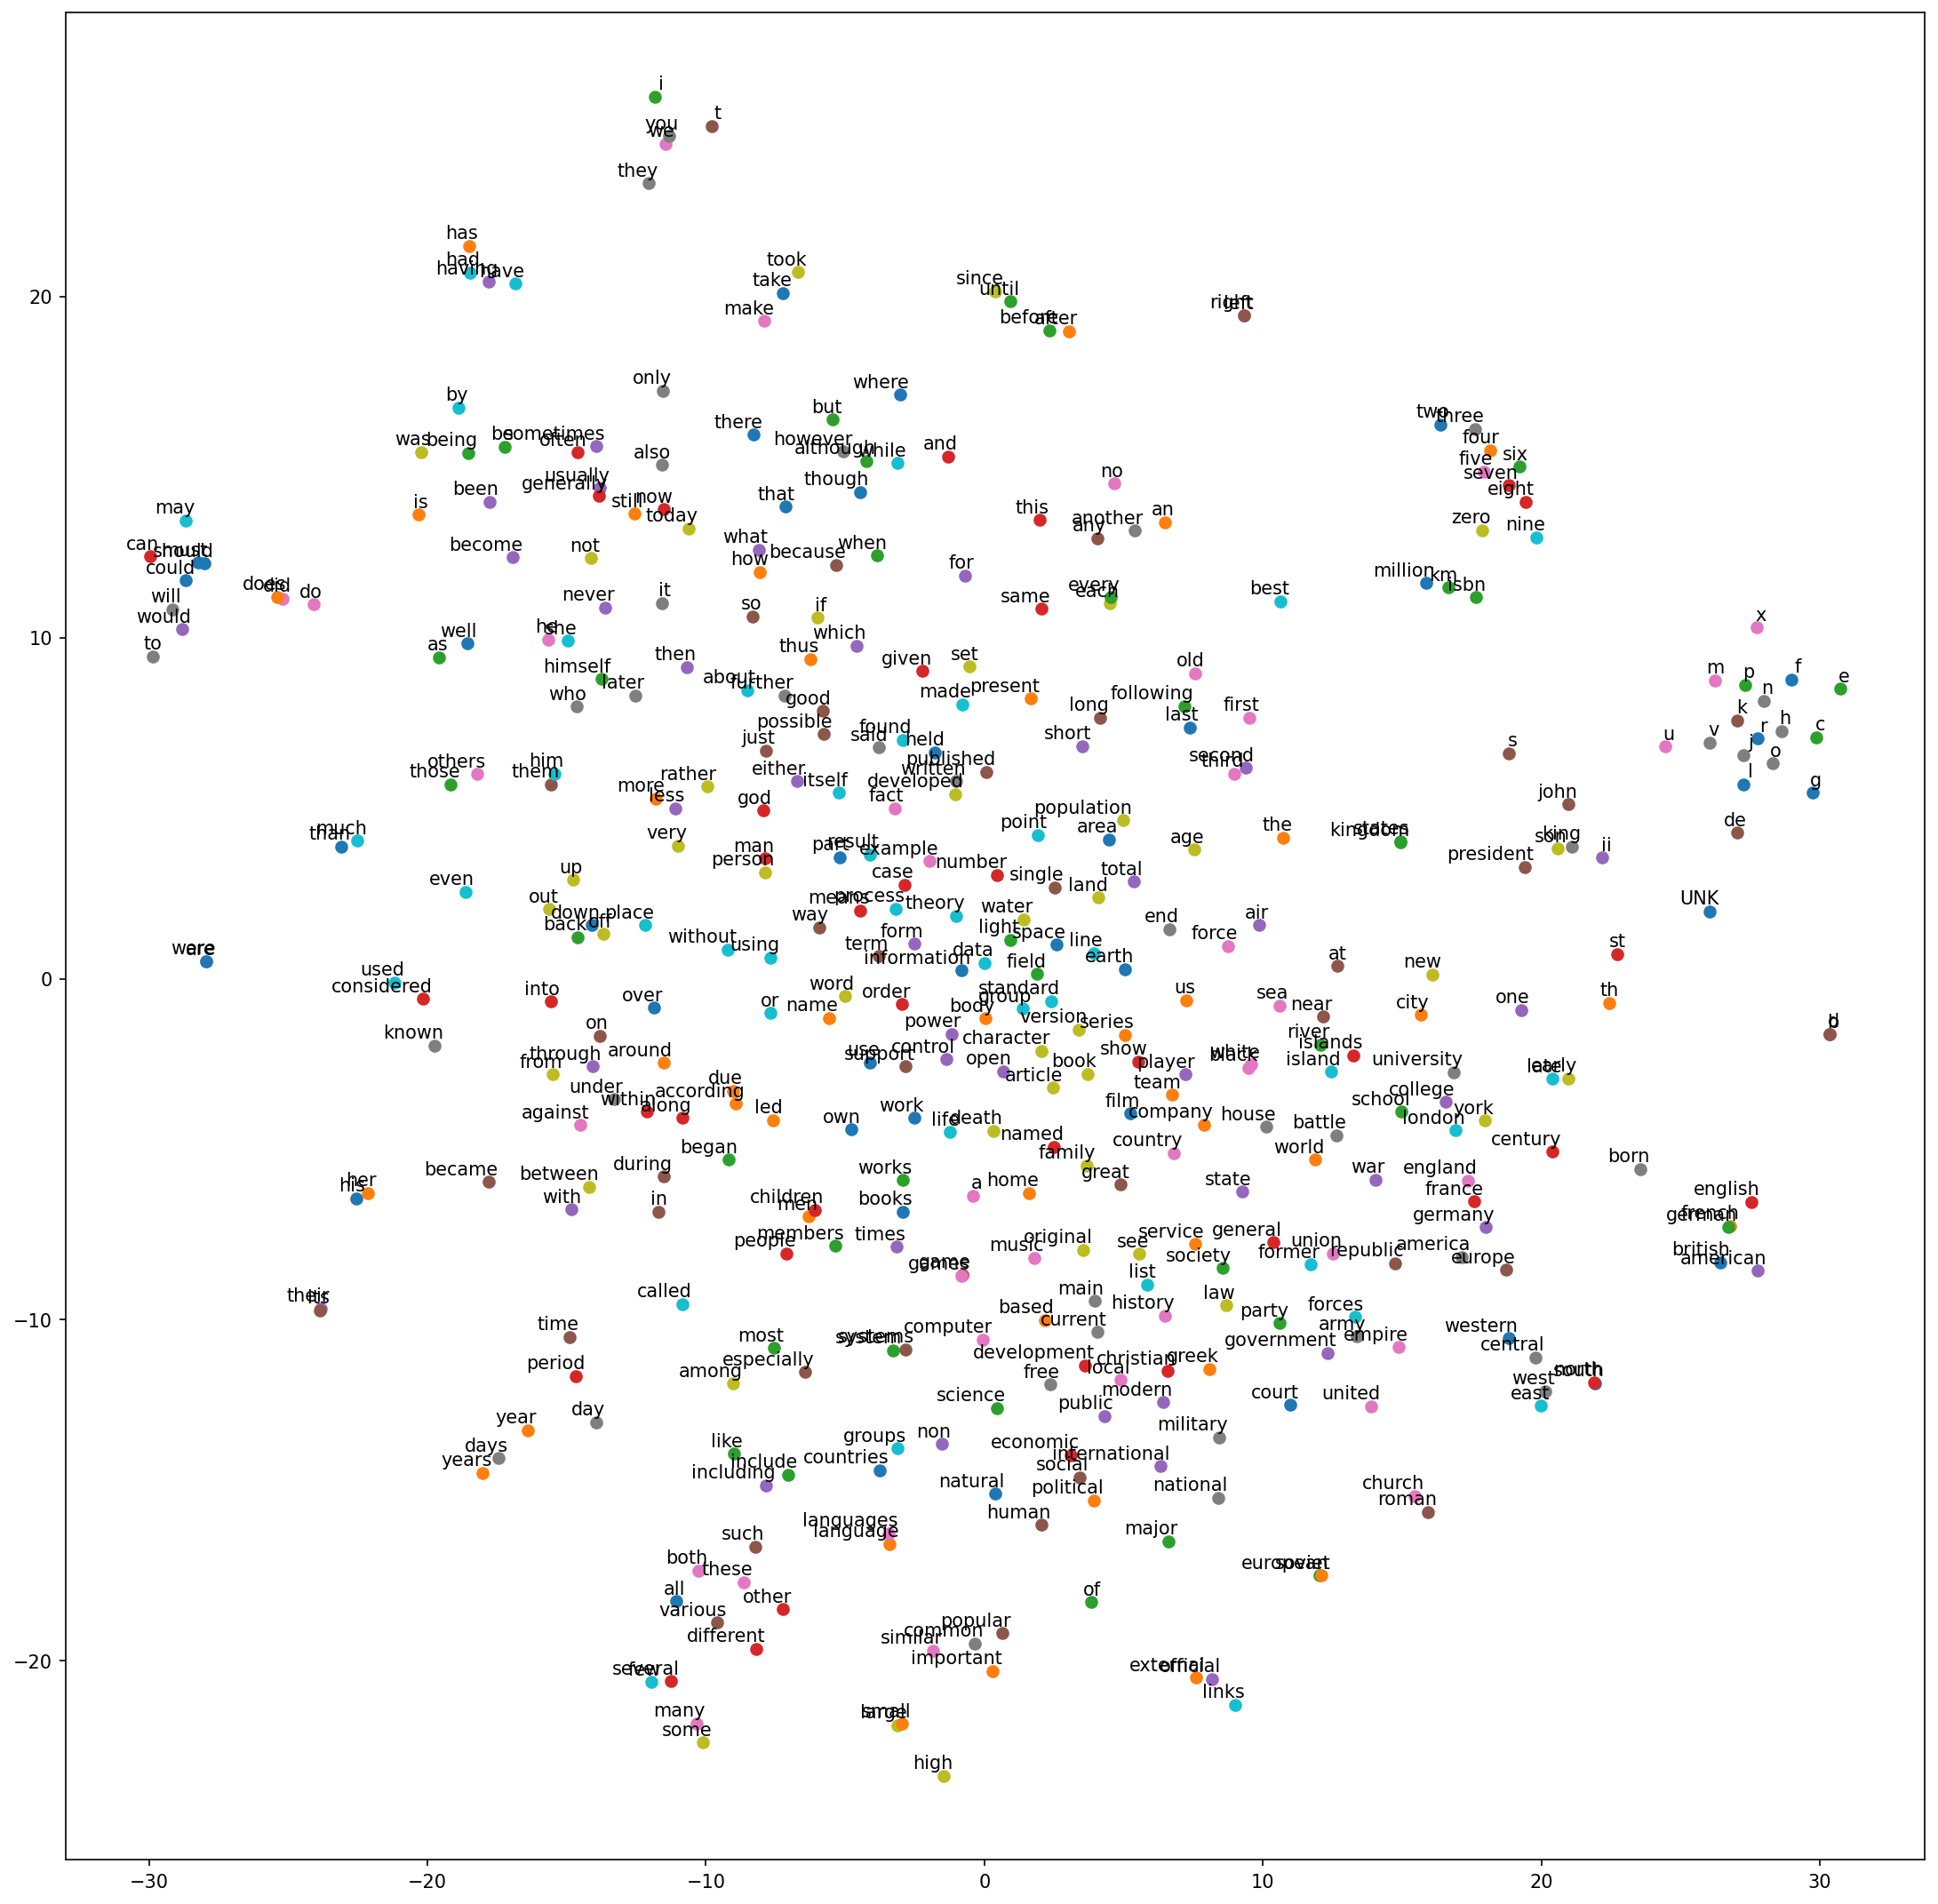

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', learning_rate='auto')
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

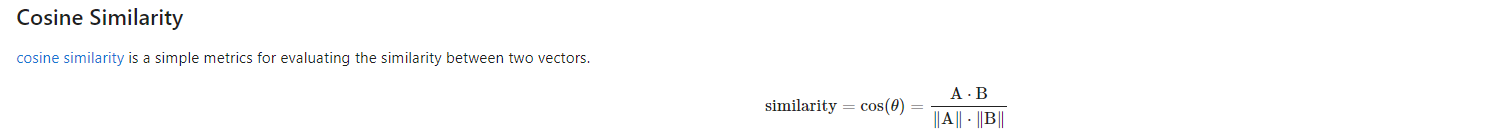

In [25]:
import numpy.linalg as LA

In [26]:
# handy method for calculating the similarity between 2 word
def cos_sim(word1, word2):
    id1 = word_to_id[word1]
    id2 = word_to_id[word2]
    
    vec1 = embedding_matrix[id1].numpy()
    vec2 = embedding_matrix[id2].numpy()

    return np.dot(vec1, vec2) / (LA.norm(vec1) * LA.norm(vec2))

In [27]:
cos_sim('cat', 'dog'), cos_sim('man', 'woman')

(0.9864097, 0.929228)

In [28]:
def top_k_nearest(word, k):
    vec = embedding_matrix[word_to_id[word]]
    
    # calaulate cosine similarity  of `vec` and all other vocabularies
    dot = np.dot(embedding_matrix.numpy(), vec)
    embedding_norm = LA.norm(embedding_matrix.numpy(), axis=-1)
    vec_norm = LA.norm(vec)
    norm_product = embedding_norm * vec_norm
    cos_sim = dot / norm_product
    
    # print out top k nearest words
    indices = np.argsort(cos_sim)[::-1][:k]
    print('---top {} nearest words of {}---'.format(k, word))
    for idx in indices:
        print(id_to_word[idx])
    print('\n')

In [29]:
top_k_nearest('england', 5)
top_k_nearest('rock', 5)

---top 5 nearest words of england---
england
spain
scotland
france
italy


---top 5 nearest words of rock---
rock
jazz
blues
punk
pop


